# LOYALTY TEST

## DSCI 100 (107) Group Project

Diya Dodhia (55120836), Raj Dhillon (17571522), Oliver 

### Introduction 

The "supermarket_sales.csv" dataset created by Aung Pyae on Kaggle approximately 3 years ago will be manipulated for the project (Pyae, 2019). The set contains data regarding 3 different supermarket branches sales across a 3 month period. 

Supermarkets are often competing with one another due to demand for food and sanitary resources. Customer loyalty is one of key ingredients in having a profitable store, thus, the goal of the project is to perform classification on sales data from branch (**A**) to predict whether a person would be a store member or not based on gender, customer satisfaction rating, and total price of invoice.

The predictors used for the K-nearest neighbour classification in the project are: 
- *Gender* : The gender of the customer (1 = female, 2 = male)
- *Rating* : The customer satisfaction rating on the overall shopping experience (scale of 1 to 10)
- *Total* : Total price of goods including *unit_price*, *quantity*, and *Tax_5%*

Variable for which class will be predicted is: 
- *Customer_type* : Type of customer, either a member or not (recorded as 'member' for members and 'normal' for non-members)

Other variables from the dataset are not used as predictors since they display insignificant data with respect to classification. *Invoice ID*, *Branch*, *City*, *Date*, and *Time* are insignificant since they only help identify where the purchase was made and when. *unit_price*, *quantity* and *Tax_5%* variables are not displayed either since they are included in *total* which is a predictor. 

Through the following process, the predictors will be used to classify any customer either as a member or not a member (normal).

## Method and Reasoning for Classification with K-Nearest Neighbours

**What is classification with K-nearest neighbours**

Label of a new observation could be predicted with KNN-Classification. This form of classification finds the nearest or most similar observations to the new label in the training set and then predicts the label's class. The K in the classification represents the number of neighbours closest to the new observation and it is commonly chosen in advance. 

**Why is classification with K-nearest neighbours chosen over KNNR (K-nearest neighbour regression)**

There are two different tools that exist for statistical problems and they both utilize K-nearest neighbours (KNN). KNN is used for both classification and regression, with the difference between the two being related to how the output is calculated. KNN classification calculates its output in a qualitative manner, however, KNN regression calculates the output in a quantitative form. Given that KNN classification calculates qualitatively, it would be appropriate to use classification since the project focuses on predicting a class not a numerical value. 

### Classification Procedure

**Importing Libraries** 

The data is read into R witht the addition of various libraries. The **tidyverse** package is included since it contains critical functions for loading, wrangling and visualizing data. The **repr** package is included since it is useable when adjusting a graph’s width and height. **Tidymodels** is included since it has tools for making and using models. Tidymodels is able to maintain the code to be simple, readble, and accurate. **Dplyr** is included since it is beneficial for data manipulation. The **stringr** package is added since it is required in a step later on which involves converting 'spaces' between variables to 'underscores(_)'. 

In [2]:
#library() is used to load packages into R (tidyverse), (repr), (tidymodels), (dplyr), (stringr)

library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
if (!require("stringr")) install.packages("stringr")
library('stringr')
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Reading the Data into R from the web** 

The data is read directly from the web since it is stored in the group GitHub repository. The data is read by the **read_csv** function which is from the tidyverse library. 

In [3]:
#The dataset is referred to supermarket 

supermarket <- read_csv('https://raw.githubusercontent.com/rajdhillon27/DSCI-classification-/main/supermarket_sales.csv')


Parsed with column specification:
cols(
  `Invoice ID` = col_character(),
  Branch = col_character(),
  City = col_character(),
  `Customer type` = col_character(),
  Gender = col_character(),
  `Product line` = col_character(),
  `Unit price` = col_double(),
  Quantity = col_double(),
  `Tax 5%` = col_double(),
  Total = col_double(),
  Date = col_character(),
  Time = col_time(format = ""),
  Payment = col_character(),
  cogs = col_double(),
  `gross margin percentage` = col_double(),
  `gross income` = col_double(),
  Rating = col_double()
)



**Converting spaces ( ) into underscores (_)** 

The **str_replace_all** function is used from the stringr library since it is able to convert the spaces between dataset variables to underscores. Spaces are converted to underscores to help R recognize the variables in the set. 

In [4]:
# all of the variable names are converted to have underscores rather than spaces

names(supermarket) <- str_replace_all(names(supermarket), " ", "_")

**Tidying and selecting revelant variables** 

Prior to selecting all of the relevant variables, the mutate function from tidyverse is used to convert *Customer_type* to a categorical term. It is converted by the use of the **as_factor** tool to create two different categories for future classification prediction.  *Gender* is also converted from a factor to a numerical value with the **as_numerical** tool to make it a readable predictor in KNN classification.



In [5]:
supermarket_sales <- supermarket%>%
    mutate(Customer_type = as_factor(Customer_type), Gender = as.numeric(as_factor(Gender)))
supermarket_sales_select <- supermarket_sales%>%
                            select(Gender, Total, Rating, Customer_type, Branch) %>%
                            filter(Branch == 'A')
head(supermarket_sales_select, 5)

Gender,Total,Rating,Customer_type,Branch
<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,548.9715,9.1,Member,A
2,340.5255,7.4,Normal,A
2,489.0480,8.4,Member,A
2,634.3785,5.3,Normal,A
1,433.6920,5.8,Member,A


Table 1: *first 5 rows of the data with relevant predictors: Gender, Total, and Rating*

## Exploration and Visualization to find the best **K**

**Splitting the data into training and testing sets with the addition of the seed**

The first step of KNN classification requires splitting of the data into two distinct sets: a training and testing set. The training set is first used to build an accurate predicting algorithm while the testing set is used for predictive purposes. Seed for the project has been added and its works on ensuring that all numerical values are reproducible throughout.

In [6]:
# Randomly seperating the dataset into 70% training set and 30% testing set 
# Customer_type set as the response variable

set.seed(1)
supermarket_split <- initial_split(supermarket_sales_select, prop = 0.70, strata = Customer_type) 
supermarket_train <- training(supermarket_split)
supermarket_test <- testing(supermarket_split)

### Production of KNN Classification Model

**Creating the recipe** 

A recipe is created for the training set by the **recipe()** function from tidyverse. The recipe displays *Customer_type* to be the response variable to the chosen predictors. Due to the numerical distance between the variables, all values are scaled and centered.

In [7]:
supermarket_recipe <- recipe(Customer_type ~ Gender + Total + Rating , data = supermarket_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

**Creating validation and training sets from training data**

**vfold_cv()** function from tidyverse is used to optimize the K value. The function seperated the training data into 5 v folds containing both a training and validation set. Function also ensures correct proportions of each predictor in each fold. 

In [8]:
# seperating the training set into 5 v folds

supermarket_vfold <- vfold_cv(supermarket_train, v = 5, strata = Customer_type)

**Creating a tuned classification model**

A tuned model for KNN classification is made with no specific number of K. The **tune()** function instead will create a model displaying various K values with their respected accuracies.

In [9]:
# creation of a tuned KNN classification model 

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

**Fitting detail into a workflow** 

All of the products from above are put to use by the **workflow()** function from tidyverse. Workflow is able to speed the process by removing the need for minor functions such as prep() and bake(). Workflow applies the classifier to the scaled and centered folds with various values for *K*. 

In [10]:
# calculating the accuracy of various K values

supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(knn_spec) %>%
     tune_grid(resamples = supermarket_vfold, grid = 10)%>%
     collect_metrics()
supermarket_workflow 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5397308,5,0.01044017,Model01
2,roc_auc,binary,0.5316232,5,0.01217544,Model01
4,accuracy,binary,0.5310465,5,0.01620680,Model02
4,roc_auc,binary,0.5694130,5,0.02403793,Model02
5,accuracy,binary,0.5186279,5,0.02973307,Model03
5,roc_auc,binary,0.5471522,5,0.03782702,Model03
6,accuracy,binary,0.5186279,5,0.02973307,Model04
6,roc_auc,binary,0.5591667,5,0.04088494,Model04
7,accuracy,binary,0.5400782,5,0.02533137,Model05


Table 2: *Summary of the workflow's accuracy associated with different number of neighbours (sliced tibble to decrease visual noise)*

**Visualization of the best K**

To create an optimized model with the best k value, a visualization needs to be made displaying the relationship between different number of neighbours and accuracies associated with them.

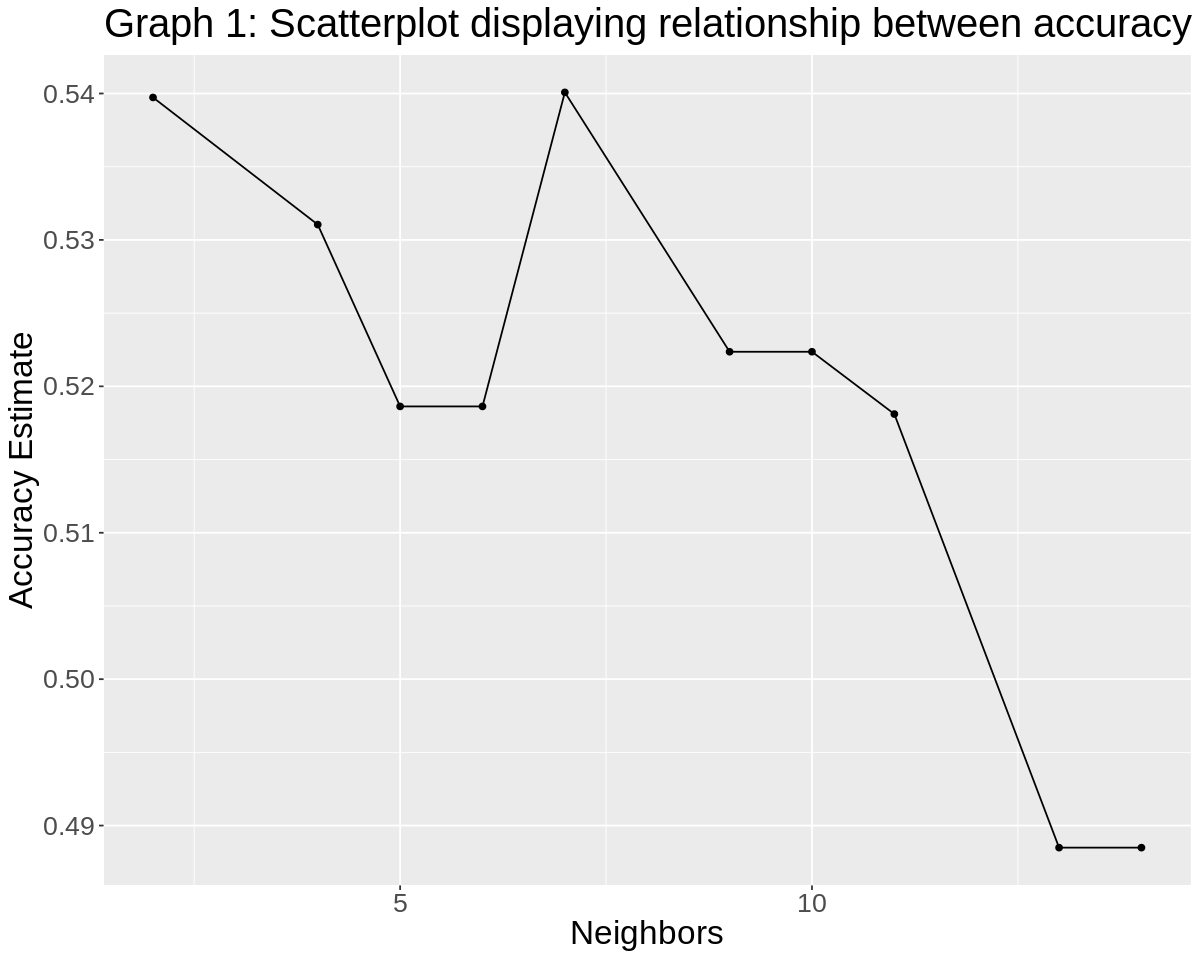

In [11]:
# filter() function removes the roc_auc from the .mectric variable
# ggplot() is used to create a visualization of neighbours vs. accuracy

supermarket_accuracies <- supermarket_workflow%>%
    filter(.metric == 'accuracy')
 
options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- ggplot(supermarket_accuracies, aes(x = neighbors, y = mean)) +
    geom_point()+
    geom_line()+
    labs(x = 'Neighbors', y = 'Accuracy Estimate') + 
    ggtitle("Graph 1: Scatterplot displaying relationship between accuracy and number of neighbours") +
    theme (text = element_text (size = 20))
cross_val_plot


*Based on the model visualization and workflow accuracy, the best number for k would be 7. The tibble produced by the workflow displays the highest accuracy when n is selected to be 7. The same could be seen on the visual demonstration.*

## Creating an Optimized Model with Best K Value '7'

**The same work is now repeated for the new found K value**

A KNN-Classification model is created with a K value of 7

In [12]:
# instead of 'tune()', neighbors is set to 7

supermarket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7)%>% 
    set_engine('kknn') %>%
    set_mode('classification')

The workflow is repeated as well for k = 7

In [13]:
# the new KNN-Classification model is inserted into the workflow 

supermarket_fit <- supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(supermarket_spec) %>%
     fit(data = supermarket_train)

The testing set is tested by the new KNN-Classification model 

In [14]:

supermarket_predictions <- predict(supermarket_fit, supermarket_test)%>%
    bind_cols(supermarket_test)
supermarket_predictions%>%
    slice(1:5)

.pred_class,Gender,Total,Rating,Customer_type,Branch
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Normal,2,340.5255,7.4,Normal,A
Normal,2,489.0480,8.4,Member,A
Member,1,441.7560,8.5,Member,A
Normal,2,752.6400,6.6,Normal,A
Member,1,19.2465,4.3,Member,A


Table 3: *summary displaying predicted class and the actual class of the customer. For the first five customers, model display 80% correct prediction however that is accurate for the entire dataset*

In [15]:
supermarket_metrics <- supermarket_predictions%>%
    metrics(truth = Customer_type, estimate = .pred_class)
supermarket_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.45544554
kap,binary,-0.09199921


Table 4: *actual accuracy of the classification model*

**Visualization of prediction and predictors**

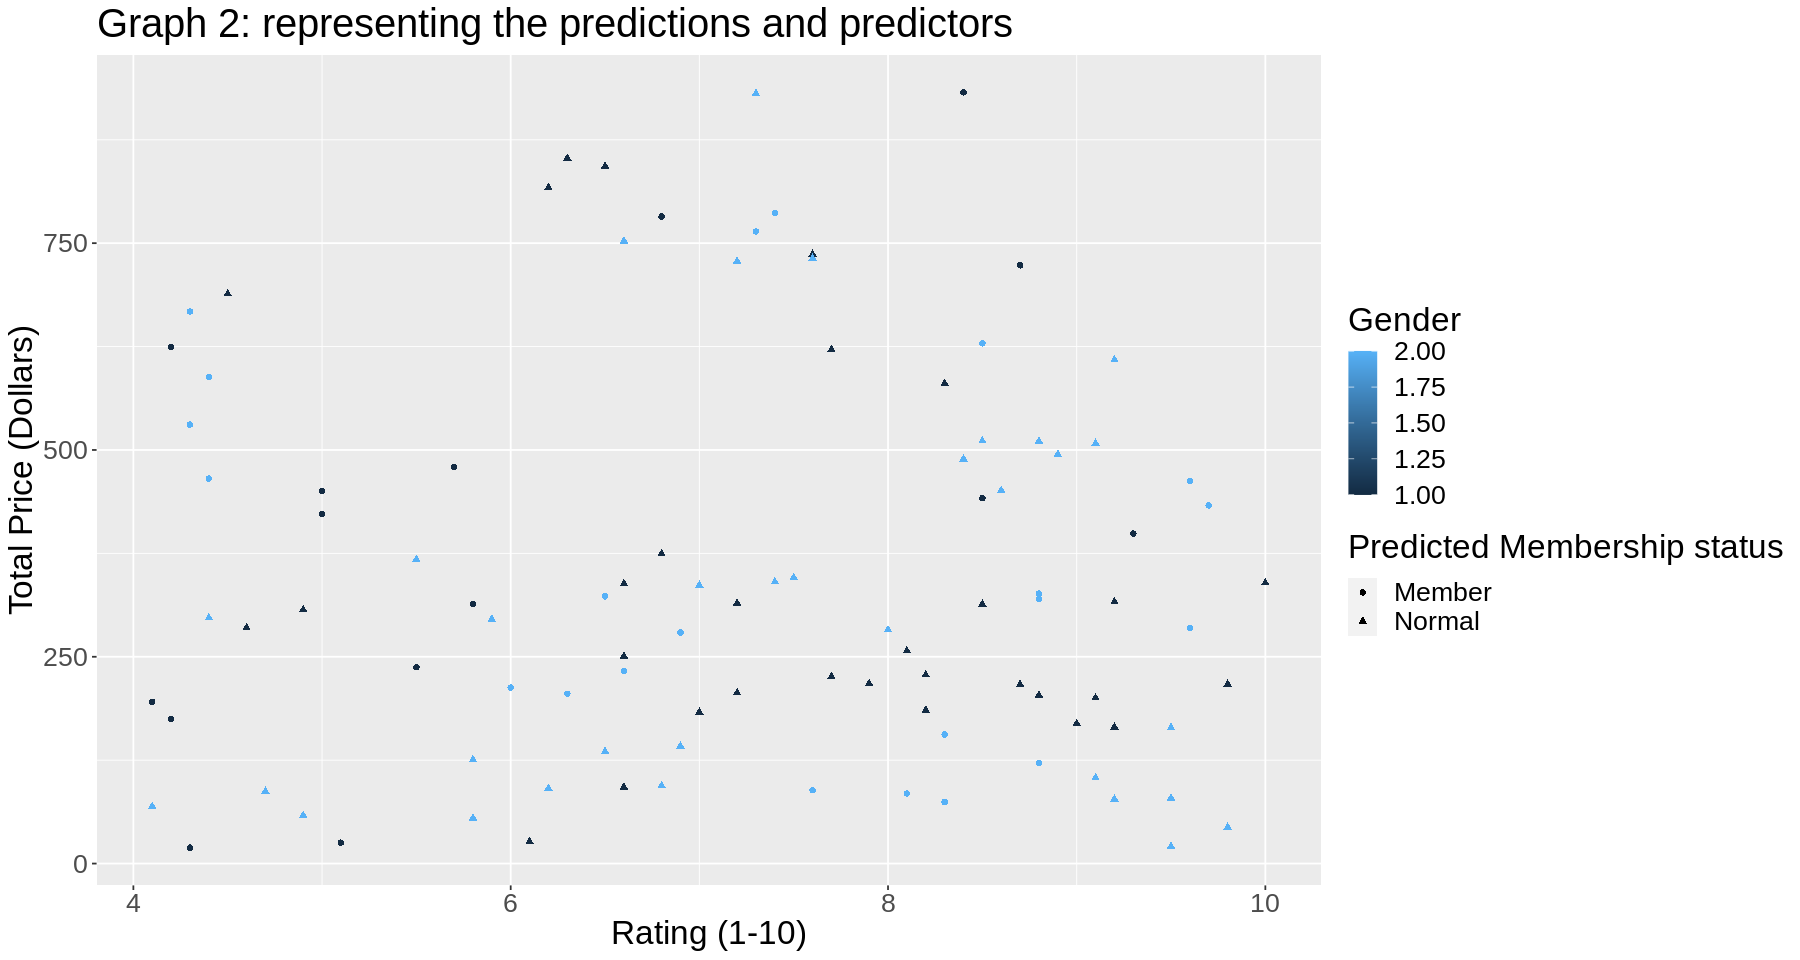

In [19]:
# model visualization created with the supermarket_prediction set

options(repr.plot.width = 15, repr.plot.height = 8)

supermarket_plot <- ggplot(supermarket_predictions, aes(x = Rating, y = Total, color = Gender, shape = .pred_class)) +
                    geom_point() +
                    labs(x = "Rating (1-10)", y = "Total Price (Dollars)", color = "Gender", shape = "Predicted Membership status") +
                    ggtitle("Graph 2: representing the predictions and predictors")+
                    theme(text = element_text(size = 20))                   
supermarket_plot

*The visualization shows no correlation between total price and customer ratings, suggesting that predictors have no effect in predicting customer type*

**Further exploration of the predictors and response variable**

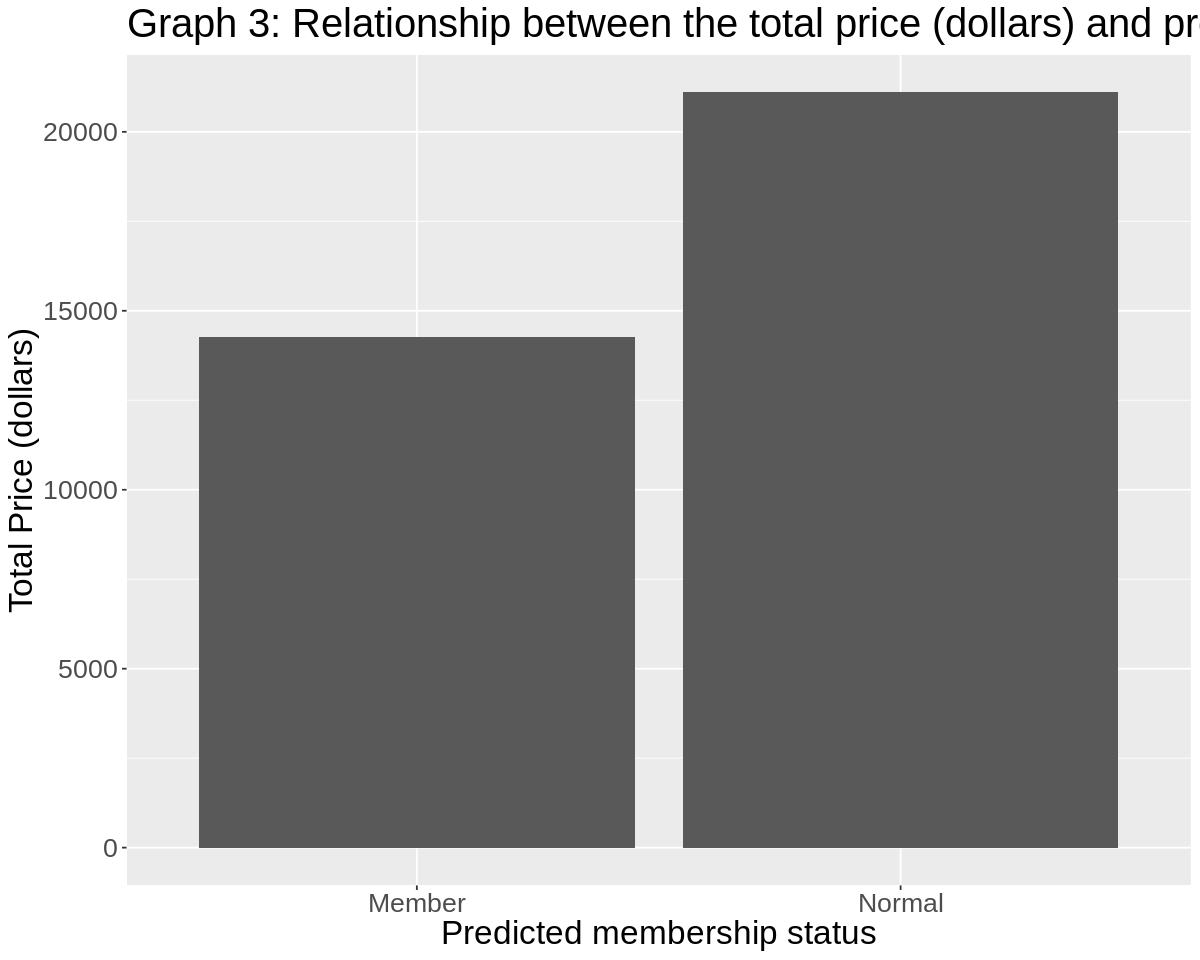

In [21]:
options(repr.plot.width = 10, repr.plot.height = 8)

total_plot <- ggplot(supermarket_predictions, aes(x = .pred_class, y = Total))+
    geom_bar(stat = "identity")+
    labs(x = "Predicted membership status", y = "Total Price (dollars)")+
    theme(text = element_text(size = 20))+
    ggtitle("Graph 3: Relationship between the total price (dollars) and predicted membership status")   
total_plot    

*Visual demonstration displays no correlation between members and total money spent in store, instead reveals reverse results with non-members spending more money on goods*

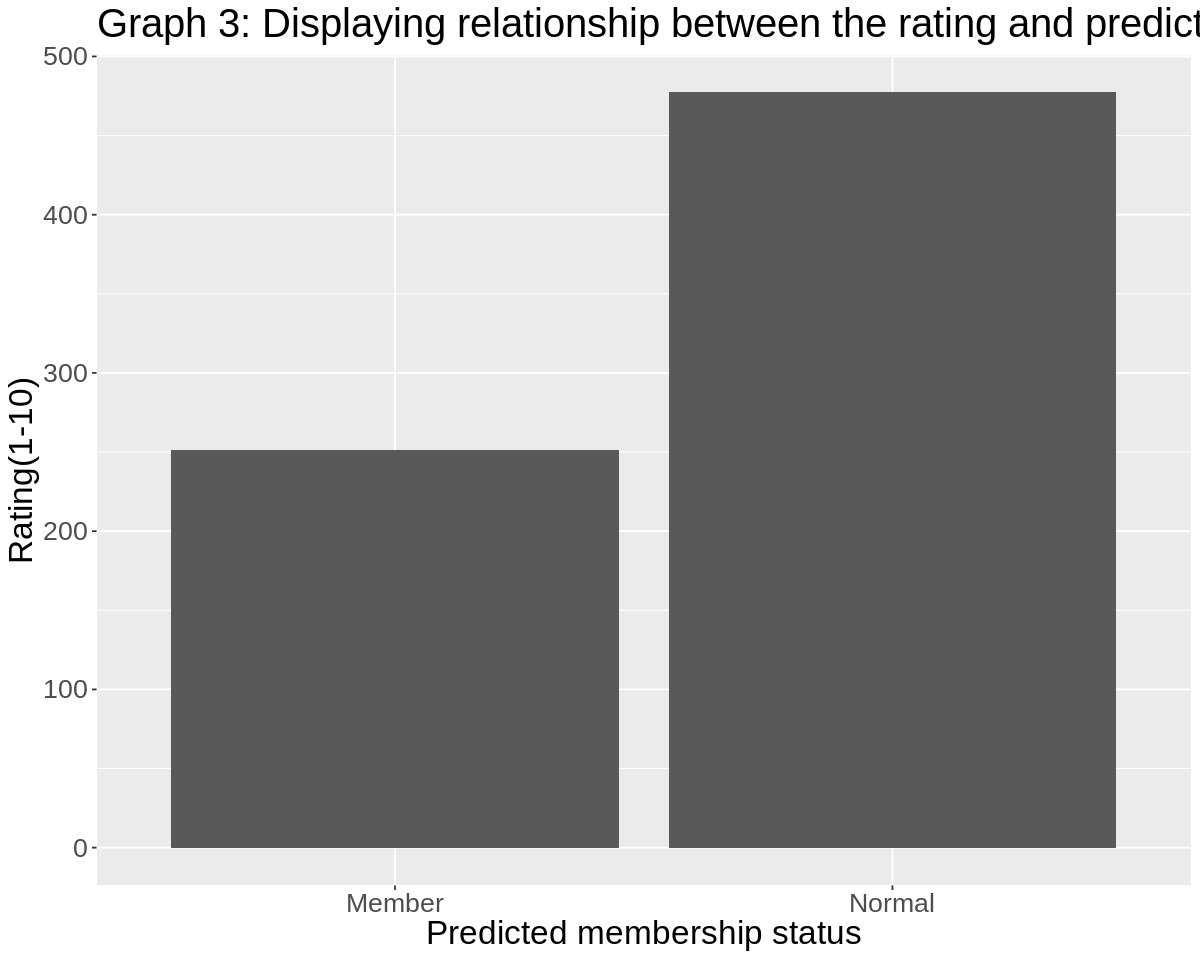

In [26]:
rating_plot <- ggplot(supermarket_predictions, aes(x = .pred_class, y = Rating))+
    geom_bar(stat = "identity")+
    labs(x = "Predicted membership status", y = "Rating(1-10)")+
    theme(text = element_text(size = 20))+
    ggtitle("Graph 3: Displaying relationship between the rating and predicted membership status")   
rating_plot  

*Visual demonstration displays no positive correlation between members and customer satisfaction rating in store, instead reveals reverse results with non-members giving a higher rating*

## Discussion

The objective of the classification analysis was to predict whether a person from branch **A** would be a store member or not based on gender, customer satisfaction rating, and total price of invoice. The project conducted was mostly not accurate since the predictors were not able to predict the right class nearly 50% of the time. Table 3 and 4, display the accuracy estimate to be between (0.55-0.45) however that was most likely the result of accurate framework. 

Intuitively, we expected there to be a strong correlation between the predictors and the response variable. The results however display no strong correlation between the predictors and class since most of the predictions were proven to be incorrect. The prediction that members would leave a higher rating was incorrect since results display non-members actually leaving more positive ratings compared to members. The prediction that members would spend more money was also proven to be incorrect since in reality non-members spent way more money shopping at the supermarket. 

Some explanations for the results could be due to the small dataset, when we decided to only observe branch A instead of all of the three branches. It is also possible that there are many other confounding variables that were not present in the set for predicting whether a person would be a member. Research by PennState suggests that different age groups respond differently to supermarket experiences, thus, supermarkets act as intergenerational zones where experience is highly dependent on the age of the consumer (Thang et al.). 

The results of this project could help markets focus on other ways to predict customer loyalty rather than gender, total spending, and rating. The predictors used in this project, show such a low correlation that markets should aim to focus on other variables such as age as suggested by PennState (Thang et al.), or inclusion of social media components as mentioned by (Nicasio, 2021). 


## References

- Nicasio, Francesca. “9 Ways to Create In-Store Experiences That Drive Traffic and Sales.” Vend Retail Blog, 8 Sept. 2021, www.vendhq.com/blog/in-store-sales-experiences. Accessed 10 Apr. 2022. 

- Pyae, Aung. “Supermarket Sales.” Kaggle, 27 May 2019, www.kaggle.com/datasets/aungpyaeap/supermarket-sales. Accessed 10 Apr. 2022.

- Thang, Leng, et al. “Let’s Go Shopping Together: Supermarkets as Intergenerational Contact Zones (Department of Agricultural Economics, Sociology, and Education).” PennState, College of Agricultural Sciences, PennState, Department of Agriculture Economics, Sociology, and Education, aese.psu.edu/outreach/intergenerational/articles/intergenerational-contact-zones/shopping-supermarkets. Accessed 10 Apr. 2022.
